# `IbIs.ipynb`

Notebook to analyze IbIs data

- ibis notes:
- triangle wave
- 0.1 Hz
- 2 V
- set QET biases to zero and Sig Gen on
    - After SQUID Tunning
- gain 1
- Auto Zero Off

In [1]:
# imports
import sys
import os
import pickle
import ipywidgets
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si

import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *

find_imports()
import qetpy as qp
import optimal_filter_utils as of

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# where to find IbIs data files
data_dir = 'D:\\B13_Runs\\Run96\\IbIs Data'
runnum = 'Ch A 4mm2'
idx = None
channel = 'A'

# will look for data files '{data_dir}/{runnum}_{i}.csv' for i in idx (unless idx = None, then remove the '_{i}')

In [4]:
# read ibis data into PicoscopeData object
ibis = PicoscopeData(runnum, data_dir = data_dir, idx = idx)

In [14]:

def plot_withlims(n1, n2, sc1, sc2):
    # plot IbIs data
    plt.figure()
    #fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

    plt.title(f'IbIs data, Ch {channel}')

    plt.xlabel('sec')
    plt.ylabel('AU')

    plt.grid()

    plt.plot(ibis.ts, ibis(channel))
    plt.plot(ibis.ts, ibis('H'))

    wind = plt.axis()

    plt.fill_betweenx((wind[2], wind[3]), 2*[ibis.ts[n1]], 2*[ibis.ts[n2]], alpha = 0.1, color = 'b')
    plt.fill_betweenx((wind[2], wind[3]), 2*[ibis.ts[sc1]], 2*[ibis.ts[sc2]], alpha = 0.1, color = 'r')

    return n1, n2, sc1, sc2

imin = 67_000
widge = ipywidgets.interactive(plot_withlims, n1 = (imin,ibis.N), n2 = (imin,ibis.N), sc1 = (imin,ibis.N), sc2 = (imin,ibis.N))

display(widge)


interactive(children=(IntSlider(value=5033500, description='n1', max=10000001, min=67000), IntSlider(value=503…

In [13]:
len(ibis.traces_df)
ibis.traces_df=ibis.traces_df.truncate(after=10000000, copy=False)
ibis.ts = ibis.traces_df['Time'].values/1e3
ibis.N = ibis.ts.size

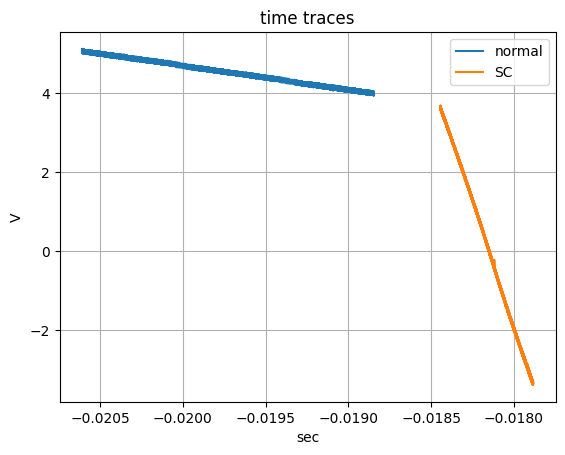

In [15]:
# normal/SC limits on IBIS data (current vs time)
n1, n2, sc1, sc2 = widge.result

n_lims = np.array([n1, n2])
sc_lims = np.array([sc1, sc2])
all_lims = np.hstack((n_lims, sc_lims))

normalinds = range(*n_lims)
scinds = range(*sc_lims)
full_sweep = range(all_lims.min(), all_lims.max())

plt.title(f'time traces')

plt.xlabel('sec')
plt.ylabel('V')

plt.grid()


plt.plot(ibis.ts[normalinds], ibis(channel)[normalinds], label = 'normal')
plt.plot(ibis.ts[scinds], ibis(channel)[scinds], label = 'SC')

plt.legend()




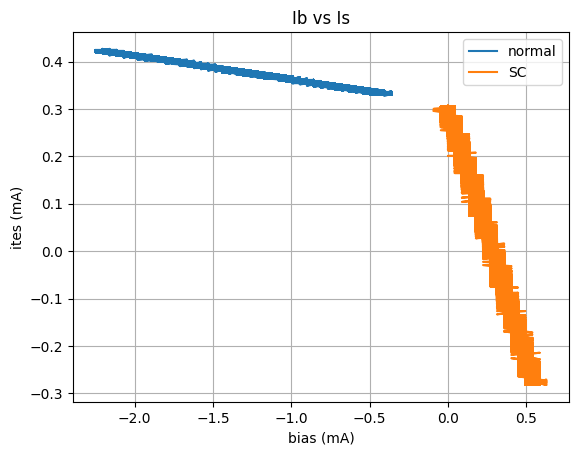

In [ ]:
# normal/SC limits on IBIS data (current vs current)

plt.figure()

plt.title(f'Ib vs Is')

plt.xlabel('bias (mA)')
plt.ylabel('ites (mA)')

plt.grid()


plt.plot(pico_to_ibias(ibis('H')[normalinds])*1e3, 1e3*to_ADC(ibis(channel)[normalinds], ibis.config), label = 'normal')
plt.plot(pico_to_ibias(ibis('H')[scinds])*1e3, 1e3*to_ADC(ibis(channel)[scinds], ibis.config), label = 'SC')

plt.legend()


In [ ]:
pscope_digitizer_err = 0.01#20/(2**12)

ibias = pico_to_ibias(ibis('H'))[np.newaxis,np.newaxis,:] # A

dites = -to_ADC(ibis(channel), ibis.config)[np.newaxis,np.newaxis,:] # A

ivfits = qp.IBIS(
    dites = dites, 
    ibias = ibias, 
    rsh = ibis.config['rsh'], 
    rsh_err = ibis.config['rsh']/100, 
    normalinds = normalinds, 
    scinds = scinds, 
    fitsc = True,
    chan_names = [channel],
    dites_err = np.full(ibias.shape, pscope_digitizer_err),
    ibias_err = np.full(ibias.shape, pscope_digitizer_err),
    )

ivfits.analyze()


In [18]:
ivfits.rnorm # normal state resistances (Ohms)

array([[0.37608835]])

In [19]:
ivfits.rp # parasitic resistances (Ohms)

array([[-0.00064486]])

Text(0, 0.5, 'resistance (Ohm)')

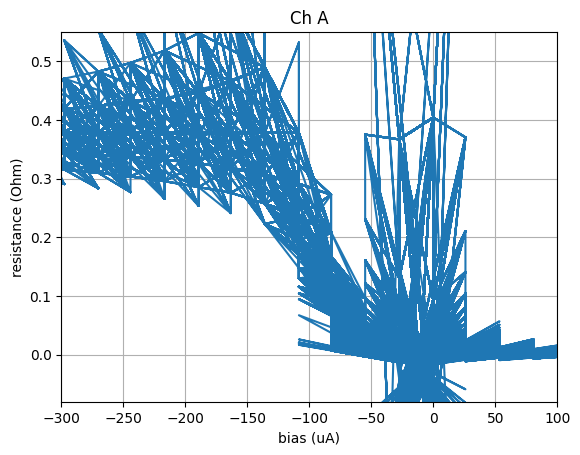

In [20]:
plt.figure()

plt.grid()
plt.title(f'Ch {channel}')
plt.plot(ibis('H')[full_sweep]*1e3, ivfits.r0[0,0][full_sweep], label = channel)
plt.ylim(-0.08, 0.55)
plt.xlim(-300, 100)
plt.xlabel('bias (uA)')
plt.ylabel('resistance (Ohm)')


Text(0, 0.5, 'resistance')

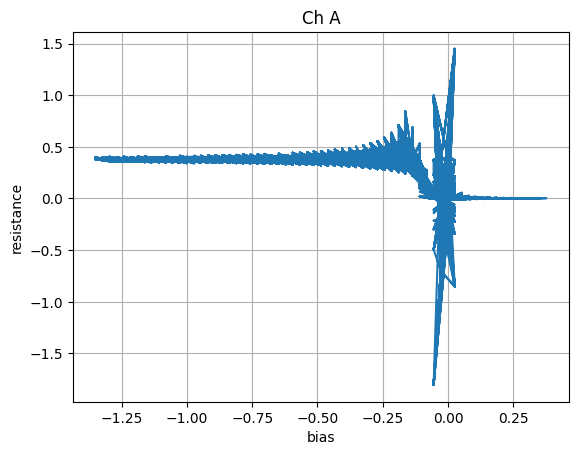

In [21]:
plt.figure()

plt.grid()
plt.title(f'Ch {channel}')
plt.plot(ibis('H')[full_sweep], ivfits.r0[0,0][full_sweep], label = channel)
plt.xlabel('bias')
plt.ylabel('resistance')


In [22]:
ivfits.rnorm

array([[0.37608835]])

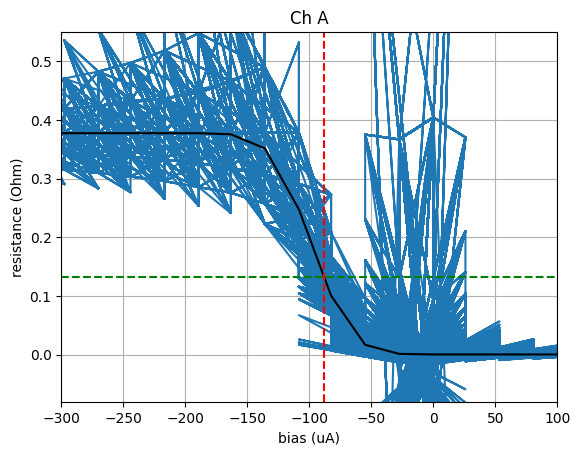

In [23]:
noise_window = (-40, 40) # uA


#sweep_without_window = np.array([i in full_sweep for i in range(ibis.ts.size)])*(~window)

def transition_curve(x,  Rn, Rsc, loc, scale,):

    return Rsc + (Rn - Rsc)*ss.erfc((x - loc)/scale)/2

def inv_transition_curve(y, Rn, Rsc, loc, scale):

    return scale*ss.erfcinv(2*(y - Rsc)/(Rn-Rsc)) + loc

plt.figure()

popt = {}
pcov = {}


plt.grid()
plt.title(f'Ch {channel}')


x = ibis('H')[full_sweep]*1e3
y = ivfits.r0[0,0][full_sweep]

window = (x > noise_window[0])*(x < noise_window[1])

xfit = x[~window]
yfit = y[~window]


popt, pcov = so.curve_fit(transition_curve, xfit, yfit, p0 = (ivfits.rnorm[0,0], 0, -80, 20))

y_opt = transition_curve(sorted(x), *popt)

plt.plot(x, y, label = channel)
#plt.plot(xfit, yfit, color = 'grey')
plt.plot(sorted(x), y_opt, color = 'k')
plt.ylim(-0.08, 0.55)
plt.xlim(-300, 100)
plt.xlabel('bias (uA)')
plt.ylabel('resistance (Ohm)')

transition_fits = pd.Series(popt)
transition_fits.name = f'Ch {channel}'
transition_fits.index = ('Rn', 'Rsc', 'loc', 'scale')

op_pt = 0.35 # operation at 35% of normal resistance

R_ops = op_pt*(transition_fits.loc['Rn'] - transition_fits.loc['Rsc']) + transition_fits.loc['Rsc']

op_pt = inv_transition_curve(R_ops, *popt)

plt.axvline(op_pt, color = 'r', linestyle = 'dashed')
plt.axhline(R_ops, color = 'g', linestyle = 'dashed')

# add data to transition_fits
transition_fits.loc['R_op'] = R_ops
transition_fits.loc['I0'] = op_pt


In [24]:
transition_fits

Rn        0.377745
Rsc       0.000583
loc     -98.237004
scale    35.792255
R_op      0.132589
I0      -88.484949
Name: Ch A, dtype: float64

In [25]:
dIb90_10 = (ss.erfcinv(2*0.1) - ss.erfcinv(2*0.9))*transition_fits['scale']
dIb90_10 # transition width from 10% of normal to 90% of normal

64.86943924069148

(-2.3949055083333333, 0.7721890083333334, -0.4623850500000001, 0.31791755)

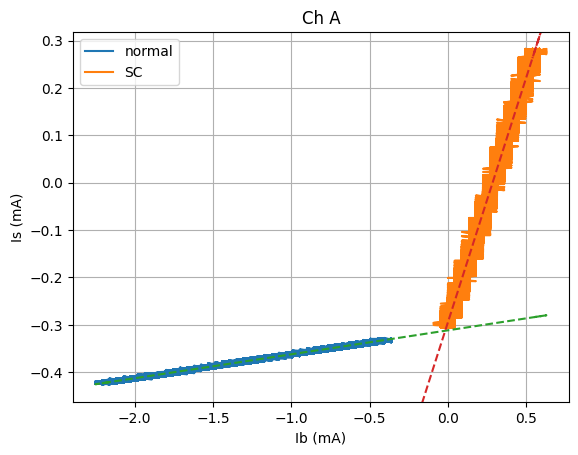

In [ ]:

plt.figure()

plt.xlabel('Ib (mA)')
plt.ylabel('Is (mA)')


plt.grid()
plt.title(f'Ch {channel}')


plt.plot(1e3*pico_to_ibias(ibis('H')[normalinds]), -1e3*to_ADC(ibis(channel)[normalinds], ibis.config), label = 'normal')
plt.plot(1e3*pico_to_ibias(ibis('H')[scinds]), -1e3*to_ADC(ibis(channel)[scinds], ibis.config), label = 'SC')

wind = plt.axis()

plt.legend()

xplot = pico_to_ibias(ibis('H')[full_sweep])

norm_fit = lambda x: ivfits.int_n[0,0,0] + ivfits.slope_n[0,0,0]*x
sc_fit = lambda x: ivfits.int_sc[0,0,0] + ivfits.slope_sc[0,0,0]*x

plt.plot(1e3*xplot, 1e3*norm_fit(xplot), '--')
plt.plot(1e3*xplot, 1e3*sc_fit(xplot), '--')


plt.axis(wind)



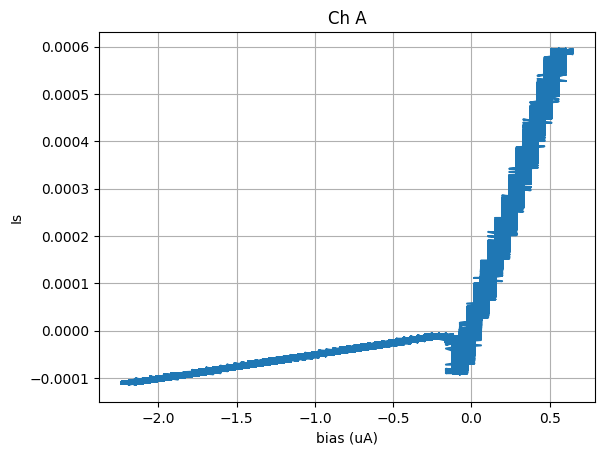

In [27]:
plt.figure()

plt.grid()
plt.title(f'Ch {channel}')
plt.xlabel('bias (uA)')
plt.ylabel('Is')


#plt.plot(ibis('H')[normalinds], -ibis(c)[normalinds], label = 'normal')
#plt.plot(ibis('H')[scinds], -ibis(c)[scinds], label = 'SC')
plt.plot(ivfits.ibias_true[0,0][full_sweep]*1e3, ivfits.ites[0,0][full_sweep])


In [28]:
# IBIS object can take multiple bias points (iters), channels (chs), and different temperatures (temps)
# input array dites has shape either (niters,), (nch,niters), or (ntemps,nch,niters)
# bias vals given in ibias (should be increasing along "iters" dimension)

# read dites/ibias data from csv
#ivdf = pd.read_csv('IV.csv', index_col = 0)

#chan_names = list(ivdf.columns)
#ibias = np.expand_dims(np.stack(len(chan_names)*[ivdf.index.values]), axis = 0)
#ibias = np.stack(len(chan_names)*[ivdf.index.values], axis = 0)[np.newaxis,:]
#dites = np.array([ivdf[c].values for c in chan_names])[np.newaxis,:]

# create IBIS object
#ivdata = qp.IBIS(
#    dites = dites, # read out current from electronics (A)
#    dites_err = np.zeros(dites.shape), 
#    ibias = ibias, # TES bias current for dites measurements (A)
#    ibias_err = np.zeros(ibias.shape),
#    rsh = didv.config['rsh'], # shunt resistance of TES circuit
#    rsh_err = 0.,
#    normalinds = np.array([0,1,2]), # indices of normal resistance points in dites (will do separate normal and SC fits)
#    #rp_guess = ,
#    #rp_err_guess = ,
#    chan_names = chan_names
#)

#ivdata.analyze()
# then e.g. grab ivdata.r0 for r0 in dict below

# IBIS objects fit (Ib,Is) data (aka (ibias/dites)) to lines of the form
# Is = A*Ib + B

# ivdata.rp = parasitic resistance in TES line
# ivdata.rnorm = normal-state resistance of TES
# ivdata.rfit = total resistance rnorm + rp + Rs
# ivdata.r0 = equiv to rnorm, but accounting for shift of the "baseline" point of the normal-mode Ib/Is line (so looking at (dites - ioff) = (rsh/(rsh+rp+r0))(ibias - ibias_off) ) '
# ---> (Is - Is0) = (Rs/(Rs+Rp+Rn))(Ib - Ib0)
# ivdata.ioff = TES current offset - point where SC and normal mode lines intersect (y-coord)
# ivdata.ibias_off = bias current offset - point where SC and normal mode lines intersect (x-coord)
# ites = dites - ioff
# ibias_true = ibias - ibias_off